https://psl.noaa.gov/data/gridded/data.coads.1deg.html
https://psl.noaa.gov/thredds/catalog/Datasets/icoads/2degree/std/catalog.html?dataset=Datasets/icoads/2degree/std/air.mean.nc

https://psl.noaa.gov/thredds/catalog/Datasets/icoads/2degree/std/catalog.html?dataset=Datasets/icoads/2degree/std/air.mean.nc
https://psl.noaa.gov/thredds/catalog/Datasets/ncep.reanalysis/Monthlies/surface/catalog.html?dataset=Datasets/ncep.reanalysis/Monthlies/surface/air.mon.mean.nc

In [1]:
# Load packages and data:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from cartopy.crs import EqualEarth, PlateCarree

from xeofs.models import EOF, EOFRotator, ExtendedEOF

import numpy as np
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
fp = '../data/air.mon.mean.nc'
air = xr.open_dataset(fp)

In [3]:
air

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 916)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2024-04-01
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    description:    Data from NCEP initialized reanalysis (4x/day).  These ar...
    platform:       Model
    Conventions:    COARDS
    NCO:            20121012
    history:        Thu May  4 20:11:16 2000: ncrcat -d time,0,623 /Datasets/...
    title:          monthly mean air.sig995 from the NCEP Reanalysis
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

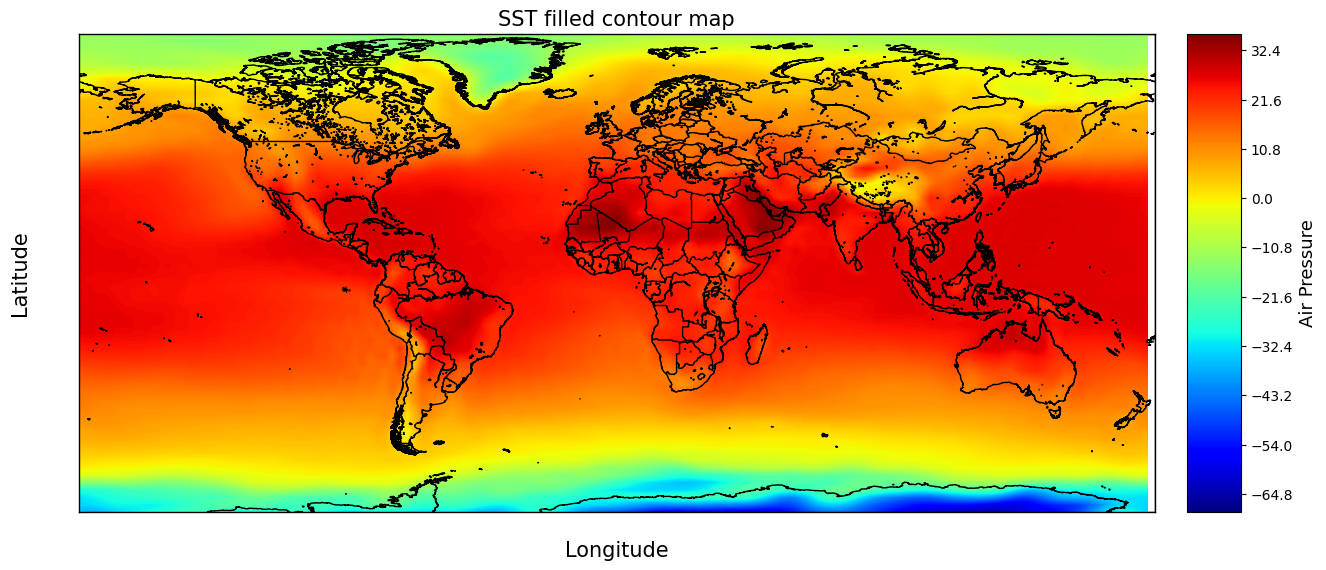

In [4]:
lats = air.variables['lat'][:]
lons = air.variables['lon'][:]
air_p = air.variables['air'][:]

###  Section added ################
# map lon values to -180..180 range
f = lambda x: ((x+180) % 360) - 180
lons = f(lons)
# rearange data
ind = np.argsort(lons)
lons = lons[ind]
air_p = air_p[:, :, ind]

##################################


fig = plt.figure(num=None, figsize=(15, 15) ) 
m = Basemap(projection='cyl', llcrnrlon=-180, llcrnrlat=-75, urcrnrlon=180, urcrnrlat=85, resolution='i')

lon, lat = np.meshgrid(lons,lats)

x, y = m(lon, lat)

st = np.squeeze(air_p[200,:,:])
# cs = m.pcolor(x, y , st, cmap='jet')
cs = m.contourf(x, y , st, cmap='jet', levels = 300)
m.drawcoastlines()
m.drawmapboundary()
m.drawcountries(linewidth=1, linestyle='solid', color='k' ) 
# m.drawmeridians(range(-80, -25, 5), color='k', linewidth=1.0, dashes=[4, 4], labels=[0, 0, 0, 1])
# m.drawparallels(range(-50, 20, 5), color='k', linewidth=1.0, dashes=[4, 4], labels=[1, 0, 0, 0])
plt.ylabel("Latitude", fontsize=15, labelpad=35)
plt.xlabel("Longitude", fontsize=15, labelpad=20)
cbar = m.colorbar(cs, location='right', pad="3%")
cbar.set_label('Air Pressure', fontsize=13)
plt.title('SST filled contour map', fontsize=15)
plt.show()

In [5]:
air['air']

<xarray.DataArray 'air' (time: 916, lat: 73, lon: 144)>
[9628992 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2024-04-01
Attributes:
    long_name:     Monthly Mean Air Temperature at sigma level 0.995
    valid_range:   [-2000.  2000.]
    units:         degC
    precision:     1
    var_desc:      Air Temperature
    statistic:     Mean
    parent_stat:   Individual Obs
    dataset:       NCEP Reanalysis Derived Products
    level_desc:    0.995 sigma
    actual_range:  [-73.78001  42.14595]

In [6]:
air_subset = air['air']
air_subset = air_subset.groupby("time.month") - air_subset.groupby("time.month").mean("time")

In [7]:
eeof = ExtendedEOF(n_modes=15, tau=1, embedding=120, n_pca_modes=50)
eeof.fit(air_subset, dim="time")
components_ext = eeof.components()
scores_ext = eeof.scores()

air_trends = eeof.inverse_transform(scores_ext.sel(mode=1))
air_detrended = air_subset - air_trends

In [8]:
eof_model_detrended = EOF(n_modes=15, standardize=True, use_coslat=True)
eof_model_detrended.fit(air_detrended, dim="time")

rotator = EOFRotator(n_modes=15)
rotator.fit(eof_model_detrended)
expvar = rotator.explained_variance()
expvar_ratio = rotator.explained_variance_ratio()
rcomponents = rotator.components()
rscores = rotator.scores()

In [9]:
print("Explained variance: ", expvar.round(0).values)
print("Relative: ", (expvar_ratio * 100).round(1).values)

Explained variance:  [602. 213. 200. 169. 169. 163. 155. 152. 150. 149. 147. 139. 138. 137.
 126.]
Relative:  [9.1 3.2 3.  2.6 2.6 2.5 2.3 2.3 2.3 2.3 2.2 2.1 2.1 2.1 1.9]


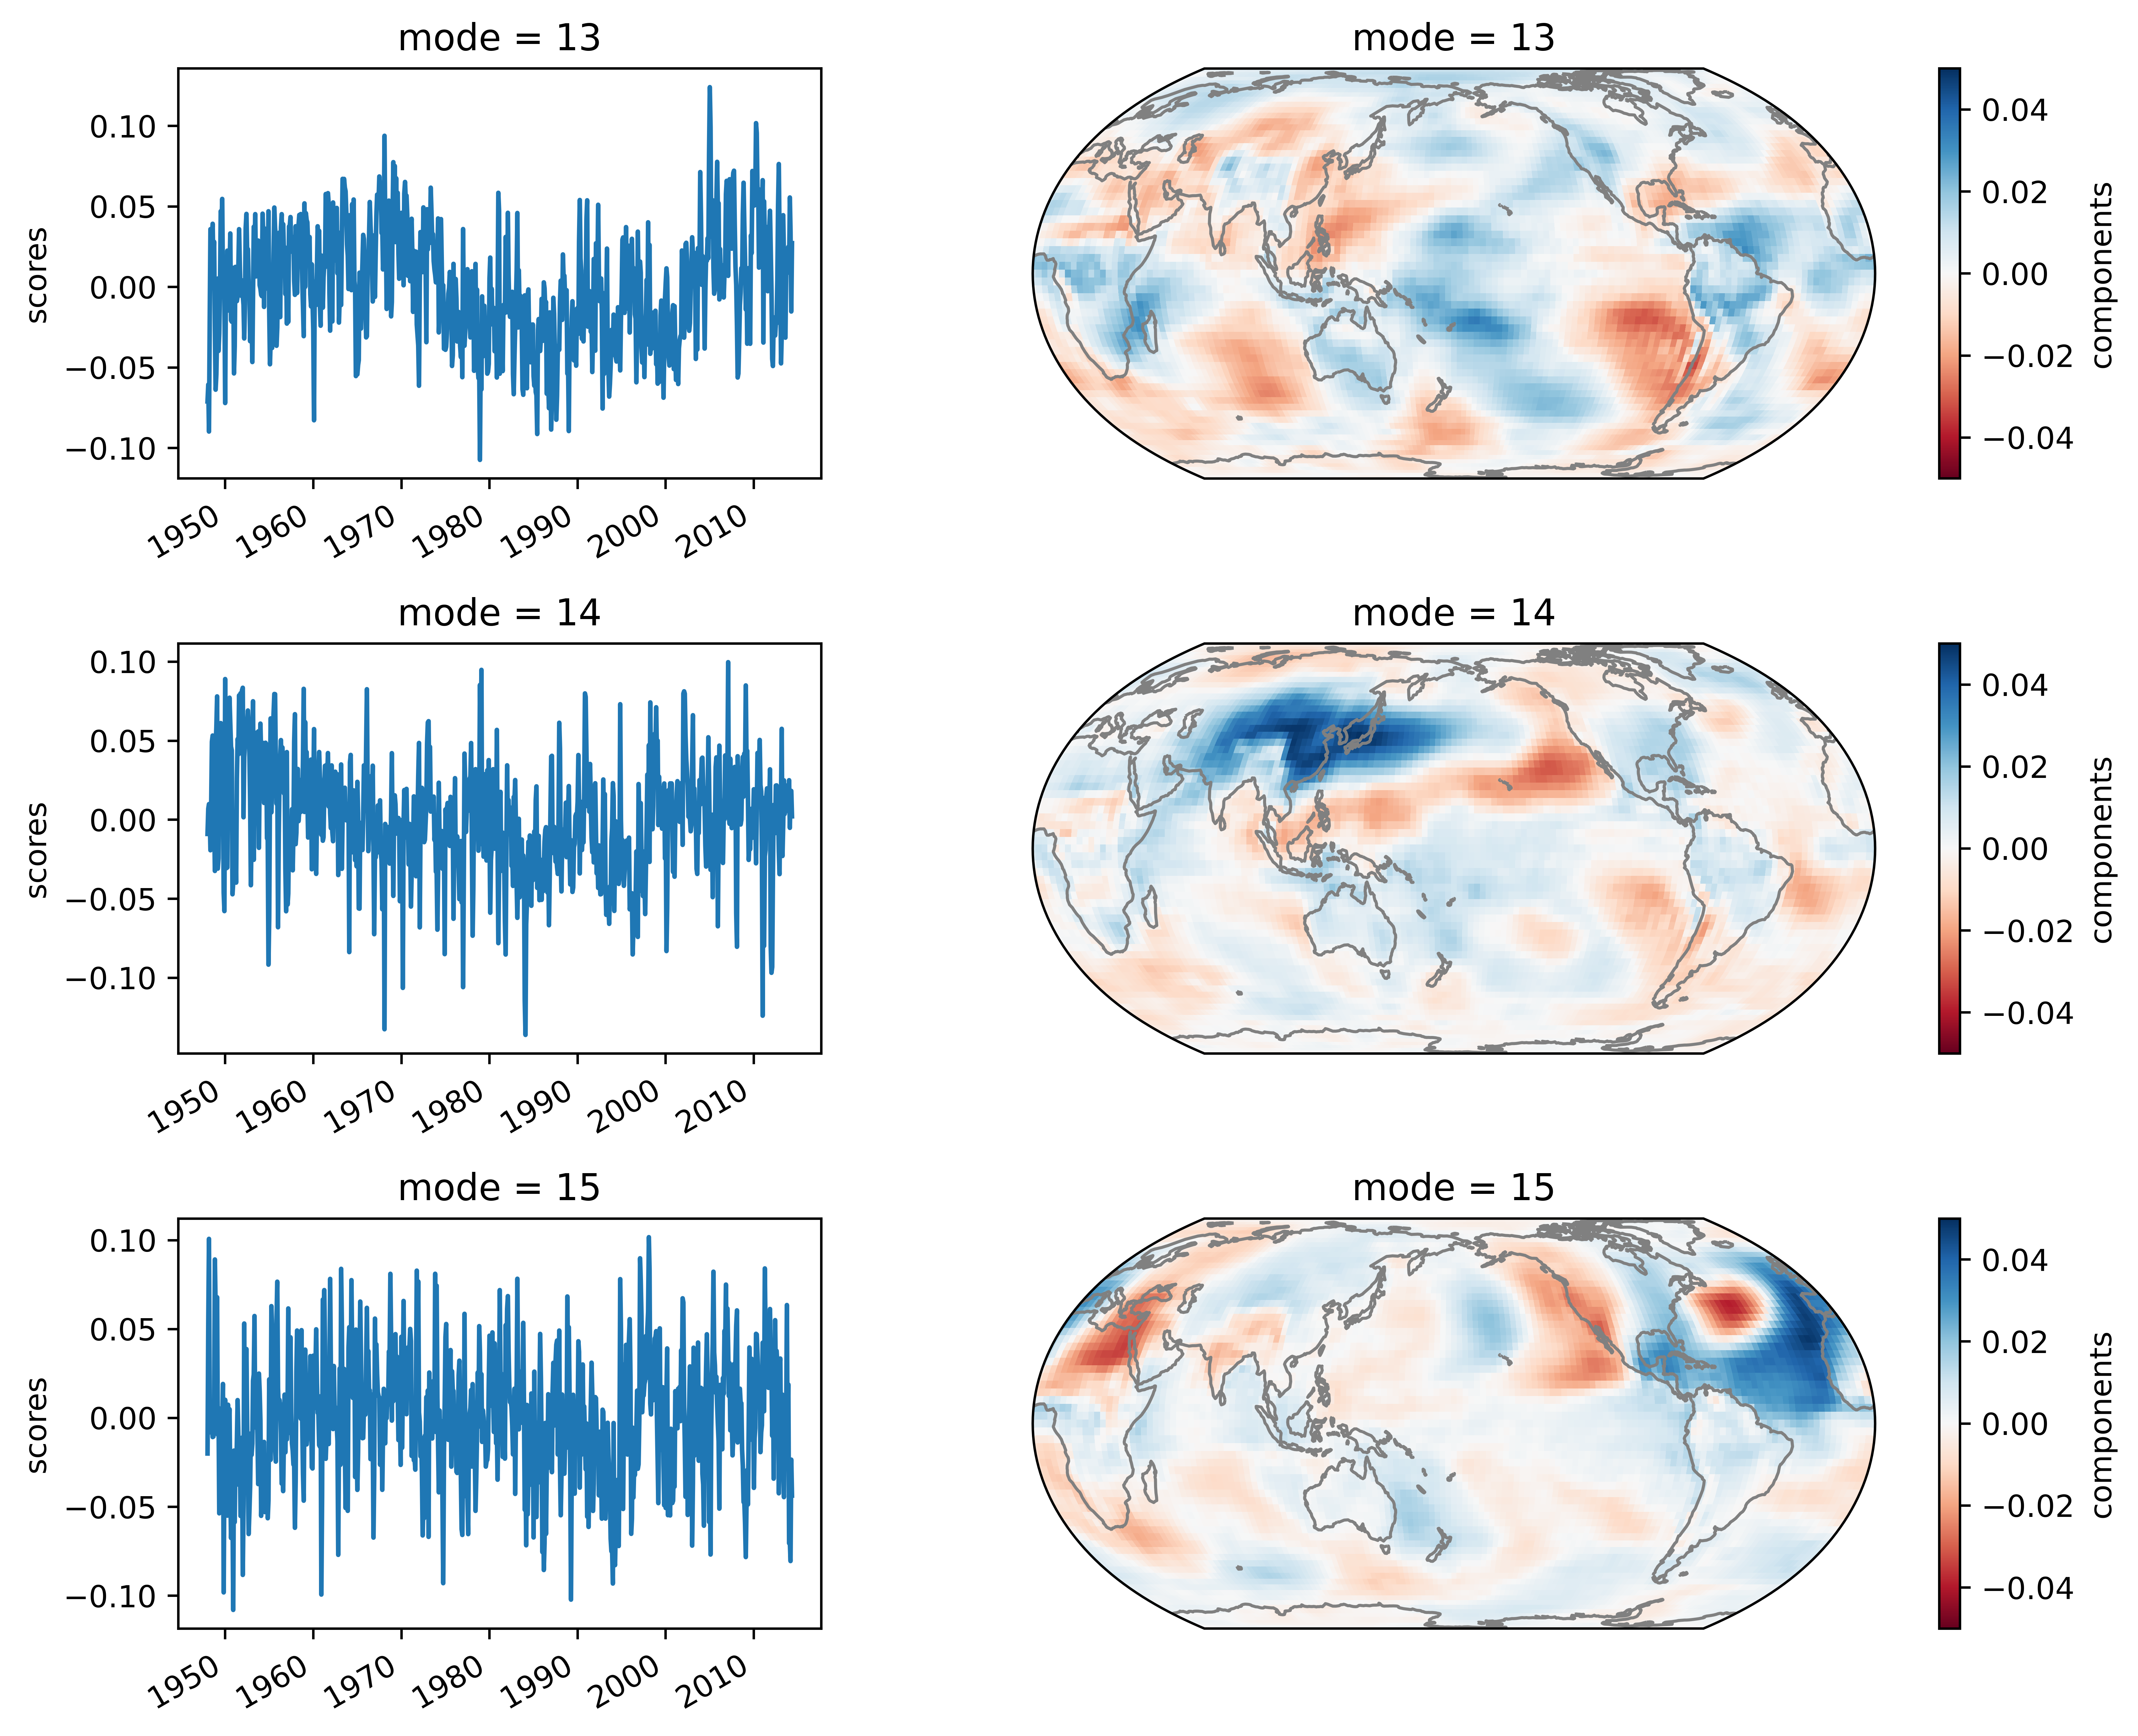

In [14]:
initial_mode=13

proj = EqualEarth(central_longitude=180)
kwargs = {"cmap": "RdBu", "vmin": -0.05, "vmax": 0.05, "transform": PlateCarree()}

fig = plt.figure(figsize=(10, 8), dpi=700)
gs = GridSpec(3, 2, width_ratios=[1, 2])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(3)]
ax1 = [fig.add_subplot(gs[i, 1], projection=proj) for i in range(3)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    rscores.sel(mode=i + initial_mode).plot(ax=a0)
    a1.coastlines(color=".5")
    rcomponents.sel(mode=i + initial_mode).plot(ax=a1, **kwargs)

    a0.set_xlabel("")

plt.tight_layout()
# plt.savefig("eof-smode.jpg")